In [41]:
'''
TaICML incremental learning
Copyright (c) Jathushan Rajasegaran, 2019
'''
from __future__ import print_function

import argparse
import os
import shutil
import time
import random
import pickle
import torch
import pdb
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from utils import Bar, Logger, AverageMeter, accuracy, mkdir_p, savefig
import logging

import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.autograd import gradcheck
import sys
import random
import collections
from tqdm import tqdm

from basic_net import *
#from learner_task_itaml import Learner
#import incremental_dataloader as data
#import rmnist_dataloader as data
import non_stationary_datasets as data
from learner_rmnist import Learner

from non_stationary_datasets import get_dataset_registry
from torch.utils.data import IterableDataset

In [ ]:
class args:
    # Place to put all logs and intermediate results
    checkpoint = "results/non_stat/"
    savepoint = "models/" + "/".join(checkpoint.split("/")[1:])
    data_path = "../Datasets/nonstationary_root"
    
    # Self explanatory 
    # n_datasets = 4
    n_way = 5
    k_shot = 5
    q_query = 15
    n_tasks = 4
    # epochs = 50   
    # iterations = 40
    # memory = 12800 
    seed = 0
    dataset = 'vggflowers'
    
    
    # test_samples_per_task = 10000
    # optimizer = 'sgd'
    # tasks_per_iter = 4

    lr = 0.01
    # train_batch = 256
    # test_batch = 256
    # workers = 16
    # sess = 1
    # gamma = 0.5
    device = 'cuda'
   
    e = 2
    r = 5
    mu = 1
    beta = .5

In [43]:
# Use CUDA
use_cuda = torch.cuda.is_available()
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if use_cuda:
    torch.cuda.manual_seed_all(args.seed)

state = {key:value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(key)}
print(state)


{'checkpoint': 'results/non_stat/', 'savepoint': 'models/non_stat/', 'data_path': '../Datasets/nonstationary_root', 'n_way': 5, 'k_shot': 5, 'q_query': 15, 'n_tasks': 4, 'seed': 0, 'dataset': 'vggflowers', 'lr': 0.01, 'device': 'cuda', 'e': 1, 'r': 20, 'mu': 1, 'beta': 0.5}


In [44]:
dataset_reg, names = get_dataset_registry(args.data_path)
test_dataset_reg, _ = get_dataset_registry(args.data_path, split = 'test')
names

ds = dataset_reg['vggflowers']
test_ds = test_dataset_reg['vggflowers']

In [45]:
class EpisodicBatcher(IterableDataset):
    def __init__(self, dataset, n_way: int, k_shot: int, q_query: int, num_tasks: int):
        self.dataset = dataset
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.num_tasks = num_tasks

    def __iter__(self):
        for _ in range(self.num_tasks):
            yield self.dataset.sample_n_way_k_shot(self.n_way, self.k_shot, self.q_query)

    def __len__(self):
        return self.num_tasks

def episodes_to_batch(episodes, args):
        """
        Stack multiple episodes into a single batch.

        episodes: list of tuples (Sx, Sy, Qx, Qy, Sg, Qg) length E=num_task_per_iter
        Returns:
          Qx_b:  [E, Bq, ...]
          Qy_b:  [E, Bq]
          dom_x: [E, Kc, ...]
          dom_y: [E, Kc]
          Sg_b:  [E, Kc] (global labels, optional downstream)
          Qg_b:  [E, Bq] (global labels, optional downstream)
        """
        device = args.device
        Kc_target = args.n_way * args.k_shot
        Kc_target = max(1, Kc_target)

        dom_x_list, dom_y_list = [], []
        Qx_list, Qy_list = [], []
        Sg_list, Qg_list = [], []

        for (Sx, Sy, Qx, Qy, Sg, Qg) in episodes:
            # to device
            Sx = Sx.to(device); Sy = Sy.to(device)
            Qx = Qx.to(device); Qy = Qy.to(device)
            Sg = Sg.to(device); Qg = Qg.to(device)

            Ns = Sx.size(0)
            if Ns == Kc_target:
                Sx_ctx = Sx
                Sy_ctx = Sy
                Sg_ctx = Sg
            elif Ns > Kc_target:
                idx = torch.randperm(Ns, device=device)[:Kc_target]
                Sx_ctx = Sx.index_select(0, idx)
                Sy_ctx = Sy.index_select(0, idx)
                Sg_ctx = Sg.index_select(0, idx)
            else:
                idx = torch.randint(low=0, high=Ns, size=(Kc_target,), device=device)
                Sx_ctx = Sx.index_select(0, idx)
                Sy_ctx = Sy.index_select(0, idx)
                Sg_ctx = Sg.index_select(0, idx)

            # Append per-episode tensors with episode dim
            dom_x_list.append(Sx_ctx.unsqueeze(0))   # [1, Kc, ...]
            dom_y_list.append(Sy_ctx.unsqueeze(0))   # [1, Kc]
            Sg_list.append(Sg_ctx.unsqueeze(0))      # [1, Kc]

            # Queries already per-episode
            Qx_list.append(Qx.unsqueeze(0))          # [1, Bq, ...]
            Qy_list.append(Qy.unsqueeze(0))          # [1, Bq]
            Qg_list.append(Qg.unsqueeze(0))          # [1, Bq]

        dom_x = torch.cat(dom_x_list, dim=0)  # [E, Kc, ...]
        dom_y = torch.cat(dom_y_list, dim=0)  # [E, Kc]
        Sg_b  = torch.cat(Sg_list,  dim=0)    # [E, Kc]

        Qx_b = torch.cat(Qx_list, dim=0)      # [E, Bq, ...]
        Qy_b = torch.cat(Qy_list, dim=0)      # [E, Bq]
        Qg_b = torch.cat(Qg_list, dim=0)      # [E, Bq]

        return Qx_b, Qy_b, dom_x, dom_y, Sg_b, Qg_b

In [ ]:
def observe(model, optimizer, Qx, Qy, dom_x, dom_y, args):
    model.train()
    
    # Qx.shape = [num_tasks, samples_per_task, *sample_shape]
    num_tasks = Qx.shape[0]
    samples_per_task = Qx.shape[1]
    sample_shape = Qx.shape[2:]
    
    num_classes = args.n_way
    
    # iTAML convention
    targets = Qy
    inputs = Qx 
    
    inputs = inputs.to(args.device)
    targets = targets.to(args.device)
    
    targets_one_hot = torch.FloatTensor(num_tasks, samples_per_task, num_classes).to(args.device)
    targets_one_hot.zero_()
    targets_one_hot.scatter_(2, targets[:, :,None], 1)
    targets_one_hot = targets_one_hot.to(args.device)
            
    
    
    train_loss = 0.0   
    
    for _ in range(args.e):  
        # Save base model
        base_params = [p.clone().detach() for p in model.parameters()]
        task_params = []
        
        for task_idx in range(num_tasks):
            # Reset params to base
            for p, base_p in zip(model.parameters(), base_params):
                p.data.copy_(base_p)
                
            # Task specific inputs/targets
            task_inputs = inputs[task_idx]
            task_targets_one_hot = targets_one_hot[task_idx]
            
            for _ in range(args.r):
                optimizer.zero_grad()
                
                _, task_outputs = model(task_inputs)
                
                loss = F.binary_cross_entropy_with_logits(task_outputs, task_targets_one_hot) 
                
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()

            task_params.append([p.data.clone() for p in model.parameters()])
        
     
        alpha = np.exp(-args.beta/num_tasks)
    
        for i,(p,base_p) in enumerate(zip(model.parameters(), base_params)):
            avg_task_param = torch.mean(torch.stack([task_p[i] for task_p in task_params]), dim=0)
            p.data.copy_(alpha * avg_task_param + (1 - alpha) * base_p)
    
    with torch.no_grad():
        model.eval()
        train_outputs = []
        for task_idx in range(num_tasks):
            logits, _ = model(inputs[task_idx])
            train_outputs.append(logits)
        train_outputs = torch.cat(train_outputs)
        combined_targets = targets.reshape(-1)
        preds = train_outputs.argmax(dim=-1)
        train_accuracy = (preds == combined_targets).float().mean().item()
    
        
    with torch.no_grad():
        model.eval()
        test_outputs = []
        for task_idx in range(num_tasks):
            logits, _ = model(dom_x[task_idx])
            test_outputs.append(logits)
        test_outputs = torch.cat(test_outputs)
        test_targets = dom_y.reshape(-1)
        test_pred = test_outputs.argmax(dim=-1)
        test_acc = (test_pred == test_targets).float().mean().item()

    avg_loss = train_loss / (num_tasks * args.e * args.r)
    return avg_loss, train_accuracy, test_acc

In [47]:
from nonstationary_feature_extractor import NonStationaryClassifier 

model = NonStationaryClassifier(dropout_p = .5, classes = args.n_way).to(args.device)
optimizer = torch.optim.SGD(model.parameters(), .01)

In [48]:
train_losses = []
train_accuracy = []
test_accuracy = []

for epoch in tqdm(range(1000)):
    # Get episodes, combine into batch
    episodes = [ds.sample_n_way_k_shot(args.n_way, args.k_shot, args.q_query) for _ in range(args.n_tasks)]
    Qx_b, Qy_b, dom_x, dom_y, Sg_b, Qg_b = episodes_to_batch(episodes, args)
    loss, train_acc, test_acc = observe(model, optimizer, Qx_b, Qy_b, dom_x, dom_y, args)
    train_losses.append(loss)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

100%|██████████| 1000/1000 [04:00<00:00,  4.15it/s]


In [49]:
final_train_accs = []
for _ in range(100//args.n_tasks):
    episodes = [ds.sample_n_way_k_shot(args.n_way, args.k_shot, args.q_query) for _ in range(args.n_tasks)]
    Qx_b, Qy_b, dom_x, dom_y, Sg_b, Qg_b = episodes_to_batch(episodes, args)
    _, _, test_acc = observe(model, optimizer, Qx_b, Qy_b, dom_x, dom_y, args)
    final_train_accs.append(test_acc)

np.mean(final_train_accs)

np.float64(0.4191999912261963)

In [50]:
final_test_accs = []
for _ in range(100//args.n_tasks):
    episodes = [test_ds.sample_n_way_k_shot(args.n_way, args.k_shot, args.q_query) for _ in range(args.n_tasks)]
    Qx_b, Qy_b, dom_x, dom_y, Sg_b, Qg_b = episodes_to_batch(episodes, args)
    _, _, test_acc = observe(model, optimizer, Qx_b, Qy_b, dom_x, dom_y, args)
    final_test_accs.append(test_acc)

np.mean(final_test_accs)

np.float64(0.41079999089241026)

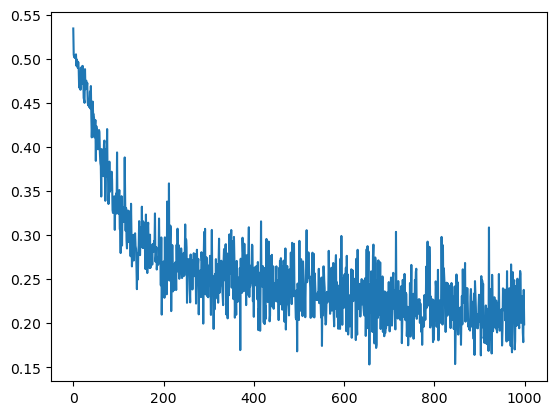

In [51]:
import matplotlib.pyplot as plt

plt.plot(train_losses)

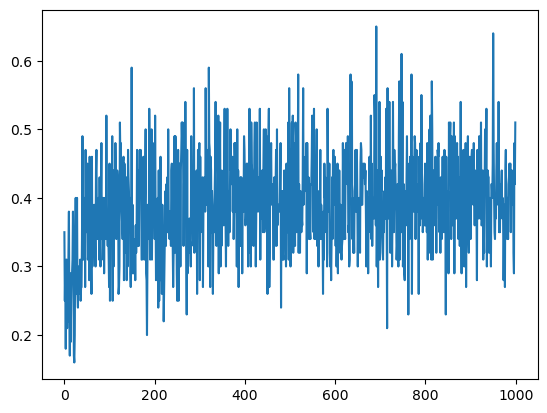

In [52]:
plt.plot(test_accuracy)